<a href="https://colab.research.google.com/github/ritaxtii/imageProcessing/blob/main/Project_ImageProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.14.0

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from keras.applications import *
from keras.applications.vgg19 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D,GlobalAveragePooling2D

In [4]:
model_xception=Xception(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 6s 0us/step


In [5]:
f1=Flatten()(model_xception.output)
final_layer = Dense(17,activation='Softmax')(f1)
model_xception=Model(inputs=model_xception.input,outputs = final_layer)
model_xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [6]:
for i,layer in enumerate(model_xception.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [7]:
#Create DataGeneartor Object
datagen = ImageDataGenerator(zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             rescale=1/255,
                             fill_mode="nearest")

In [8]:
train_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Train'
validate_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Validate'
test_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Test'

In [9]:
# Create Train Image generator
train_generator = datagen.flow_from_directory(directory=train_path,
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=16,
                                              class_mode='categorical',
                                              seed=42,
                                              shuffle=True)

Found 1625 images belonging to 17 classes.


In [10]:
# Create Validation Image generator
val_generator = datagen.flow_from_directory(directory=validate_path,
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=4,
                                            class_mode='categorical',
                                            seed=42,
                                            shuffle=True)

Found 406 images belonging to 17 classes.


In [11]:
# สร้างฟังก์ชันสำหรับแสดงรูปภาพเป็นตาราง 4x4
def plot_images(generator, num_images=16):
    # สร้าง subplot 4x4
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    # ดึงรูปภาพจาก generator
    for i in range(num_images):
        # ดึงรูปภาพ
        batch = generator.next()
        img = batch[0][0]

        # แสดงรูปภาพ
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

In [13]:
# Create Optimizer
opts = Adam(learning_rate = 0.0001, use_ema=True)
model_xception.compile(loss='categorical_crossentropy',optimizer=opts,metrics=['accuracy'])

In [14]:
# Define training Generator Parameter
EP = 20
step_size_train=train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
# check step_size_Train = step_size_val -> if not, adjust batch_size to make it equal
if step_size_train == step_size_val:
    print("step_size_train is equal to step_size_val.")
    print(f"Number of steps per epoch: {step_size_train}")
else:
    print("step_size_train is not equal to step_size_val.")
    print(f"Number of steps per epoch (train): {step_size_train}")
    print(f"Number of steps per epoch (validation): {step_size_val}")

step_size_train is equal to step_size_val.
Number of steps per epoch: 101


In [15]:
print(type(train_generator))
print(type(val_generator))
print(train_generator.image_shape)
print(val_generator.image_shape)

<class 'keras.src.preprocessing.image.DirectoryIterator'>
<class 'keras.src.preprocessing.image.DirectoryIterator'>
(224, 224, 3)
(224, 224, 3)


In [16]:
history=model_xception.fit(train_generator,
                                        steps_per_epoch=step_size_train,
                                        validation_data = val_generator,
                                        validation_steps = step_size_val,
                                        epochs=EP,
                                        verbose = 1)

Epoch 1/20
101/101 [==============================] - 1152s 11s/step - loss: 0.5322 - accuracy: 0.8552 - val_loss: 0.1578 - val_accuracy: 0.9604
Epoch 2/20
101/101 [==============================] - 47s 459ms/step - loss: 0.0292 - accuracy: 0.9932 - val_loss: 0.1348 - val_accuracy: 0.9579
Epoch 3/20
101/101 [==============================] - 44s 432ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.0105 - val_accuracy: 0.9975
Epoch 4/20
101/101 [==============================] - 45s 441ms/step - loss: 0.0108 - accuracy: 0.9950 - val_loss: 0.0243 - val_accuracy: 0.9950
Epoch 5/20
101/101 [==============================] - 46s 451ms/step - loss: 0.0179 - accuracy: 0.9963 - val_loss: 0.0332 - val_accuracy: 0.9876
Epoch 6/20
101/101 [==============================] - 44s 434ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0091 - val_accuracy: 0.9975
Epoch 7/20
101/101 [==============================] - 44s 433ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0026 - val_ac

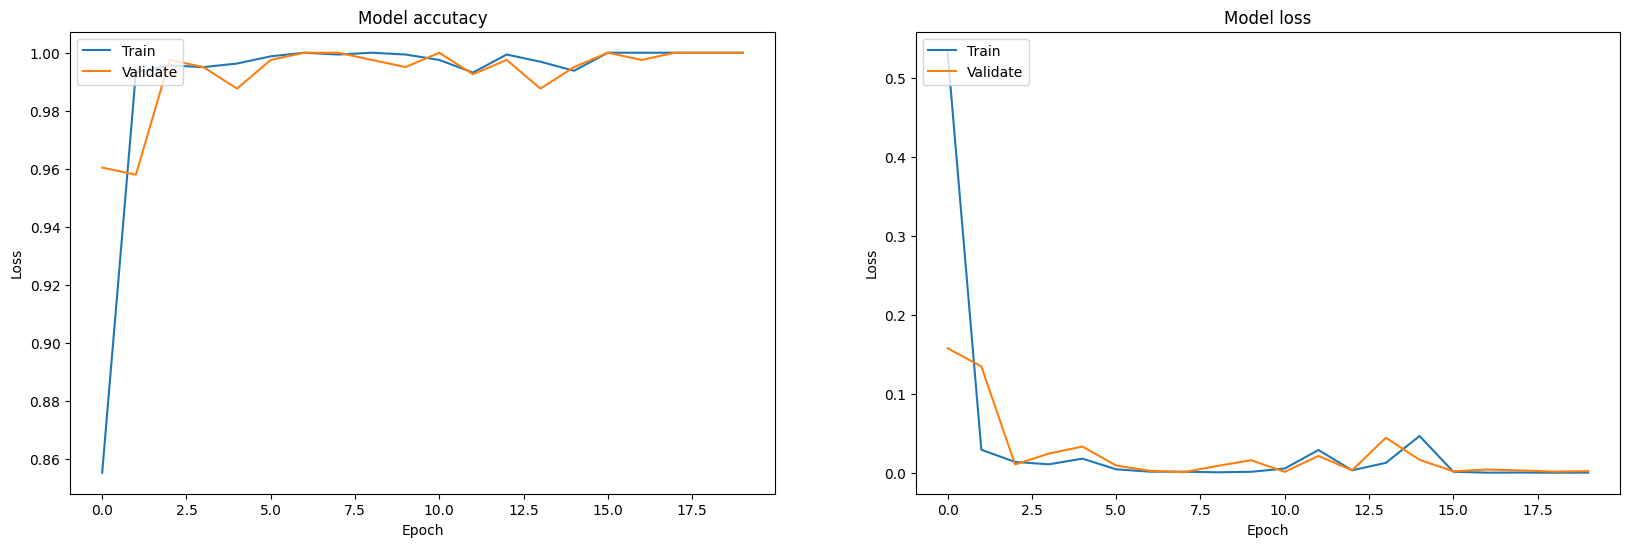

In [17]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")
plt.title('Model accutacy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')

# View Loss (Training, Validation)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')

In [18]:
# Initial test generator
Test_generator = datagen.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=(224, 224), color_mode="rgb",
    shuffle=False,
    batch_size=1)

Found 893 images belonging to 17 classes.


In [19]:
#Get class id for y_real_class
y_true = Test_generator.classes

In [20]:
print(Test_generator.class_indices)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16}


In [22]:
#predict images according to test_generator # number of real class
preds = model_xception.predict_generator(Test_generator)
print(preds.shape)
print(preds)

<ipython-input-22-ed0b40c52673>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model_xception.predict_generator(Test_generator)


(893, 17)
[[1.0000000e+00 1.6369965e-14 2.6884815e-13 ... 6.9356397e-13
  1.9353403e-13 8.5707205e-11]
 [9.9999964e-01 2.9824612e-10 1.6020046e-08 ... 1.8008514e-09
  8.8567781e-10 5.6467190e-08]
 [1.0000000e+00 1.6024747e-13 5.6691995e-12 ... 2.0569403e-12
  1.4321356e-12 2.5510399e-10]
 ...
 [2.2495725e-10 7.5511841e-10 1.8979735e-12 ... 1.0225212e-09
  1.0708213e-08 1.0000000e+00]
 [5.3664872e-12 1.1895727e-10 7.2876967e-14 ... 6.5454898e-12
  2.3624505e-11 1.0000000e+00]
 [6.8102864e-11 1.8303978e-09 8.5276144e-13 ... 2.4551873e-11
  9.0925621e-11 1.0000000e+00]]


In [23]:
y_pred = np.argmax(preds,axis=1)
print(Test_generator.classes)
print(y_pred)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6

In [24]:
#Calculate confusion matrix, classification report between y_true and df_class

#print(confusion_matrix(y_true, y_pred))
# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Get the number of classes
num_classes = confusion.shape[0]

# Create a formatted confusion matrix with class labels
formatted_confusion = np.zeros((num_classes, num_classes), dtype=int)

for i in range(num_classes):
    for j in range(num_classes):
        formatted_confusion[i, j] = confusion[i, j]

# Print the formatted confusion matrix
print("Confusion Matrix:")
for i in range(num_classes):
    row = "Class " + str(i) + " | "
    for j in range(num_classes):
        row += str(formatted_confusion[i, j]) + " "
    print(row)
print(classification_report(y_true, y_pred))

Confusion Matrix:
Class 0 | 35 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 1 | 0 78 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 2 | 0 0 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 3 | 0 0 0 58 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 4 | 0 0 0 0 45 0 0 0 0 0 0 0 0 0 0 0 0 
Class 5 | 0 0 0 0 0 64 0 0 0 0 1 0 0 0 0 0 0 
Class 6 | 0 0 0 0 0 0 28 0 0 0 0 0 0 0 0 0 0 
Class 7 | 0 0 0 0 0 0 0 38 0 0 0 0 0 0 0 0 0 
Class 8 | 0 0 0 0 0 0 0 0 42 0 0 0 0 0 0 0 0 
Class 9 | 0 0 0 0 0 0 0 0 0 39 0 0 0 0 0 0 0 
Class 10 | 0 0 0 0 0 0 0 0 0 0 30 0 0 0 0 0 0 
Class 11 | 0 0 0 0 0 0 0 0 0 0 0 37 0 0 0 0 0 
Class 12 | 0 0 0 0 0 0 0 0 0 0 0 0 133 0 0 0 0 
Class 13 | 0 0 0 0 0 0 0 0 0 0 0 0 0 45 0 0 0 
Class 14 | 0 0 0 0 0 0 0 0 0 0 0 0 0 0 46 0 0 
Class 15 | 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 97 0 
Class 16 | 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78
           2       1.00      

In [25]:
invert_Test_class =  {v: k for k, v in Test_generator.class_indices.items()}
print(invert_Test_class)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q'}


1/1 [==============================] - 0s 90ms/step
[[2.2534300e-07 3.6626786e-06 9.4181155e-07 8.9412123e-07 1.3083168e-06
  3.1530931e-06 1.7021572e-06 2.9859405e-06 4.0691789e-06 9.9997044e-01
  7.3890116e-10 2.5545752e-08 2.6836943e-07 1.6785444e-06 7.2069810e-07
  9.6389172e-08 7.8738558e-06]]
Predicted class: [9]
True class: j


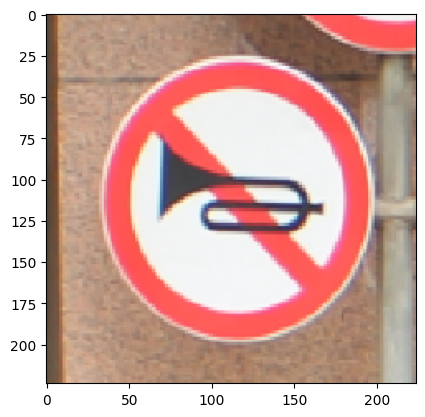

In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
image_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Test/j/017_1_0022.png'  # Replace with the path to your image
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = preprocess_input(img)  # Apply preprocessing function

# Make a prediction
predictions = model_xception.predict(img)
print(predictions)

# Get the class with the highest probability (argmax)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
print("Predicted class:", predicted_class)
print("True class:",invert_Test_class[int(predicted_class)])

In [30]:
from tensorflow.keras.models import load_model

# Save the model to an HDF5 file
model_xception.save('/content/drive/MyDrive/FinalProjectImage2/model_xception20epoch.h5')